### Importing Packages

In [1]:
import pickle
import datetime
from scipy import stats
from tqdm import tqdm
import pandas as pd
import numpy as np
import statsmodels.api as sm
from itertools import combinations
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

### Helper Functions

In [2]:
%run "../utils/functions.py"

### Load data

In [3]:
with open(
    file="../data/coin_px_vol_2022-06-24_to_2025-06-24.pkl", 
    mode="rb"
    ) as f:
    data_dict = pickle.load(f)

coin_prices = pd.concat(
    [
        data_dict[i]["price"] for i in data_dict
    ],
    axis=1
)

coin_prices.columns = [i for i in data_dict]

coin_prices = coin_prices.dropna(
    axis = 1,
    thresh = 0.99 * coin_prices.shape[0]
).ffill(limit=2).replace(np.nan, 0)

print(
    f"Crypto data from {str(coin_prices.index.min().date())} to {str(coin_prices.index.max().date())}"
    )

coin_prices.tail(4)


Crypto data from 2022-06-25 to 2025-06-24


,SOL,BTC,XRP,DOGE,ETH,ADA,BNB,TRX,AAVE,UNI,...,BICO,FIST,GMX,BAND,LRC,RARE,SKL,TWT,HNT,PHB
date,,,,,,,,,,,,,,,,,,,,,
2025-06-21,140.061295,103290.105145,2.120113,0.162332,2403.607721,0.576848,641.466075,0.272483,247.264404,7.073481,...,0.089715,0.321726,14.070058,0.584629,0.075146,0.048383,0.017951,0.722245,2.428924,0.414596
2025-06-22,133.866437,101532.568385,2.044380,0.153080,2277.899190,0.550708,626.568767,0.270289,231.713187,6.388992,...,0.085296,0.437483,13.186598,0.550390,0.071409,0.044991,0.016872,0.684994,2.251220,0.385577
2025-06-23,132.210728,100852.582646,2.013513,0.151148,2229.907577,0.541130,615.920084,0.263612,227.555713,6.260848,...,0.082184,0.434130,12.899459,0.520715,0.069055,0.043732,0.016632,0.669218,2.171437,0.374358
2025-06-24,144.786261,105511.624379,2.164008,0.164473,2422.994920,0.583240,640.254318,0.273023,258.018653,6.830906,...,0.093872,0.448770,14.122592,0.588557,0.077711,0.048367,0.018450,0.712156,2.355143,0.425652


### Step 1: Split Crypto Price Data into Training, Validation, and Test Sets Based on Date Range

Before applying any statistical analysis or building a trading strategy, it's critical to divide your dataset into well-defined time segments. This ensures that model evaluation is **realistic**, **unbiased**, and **forward-looking**, which is especially important in the volatile and non-stationary world of crypto.

By automatically splitting the dataset based on actual date ranges (instead of hardcoding dates), we maintain flexibility and prevent overfitting. This approach ensures that the strategy generalizes well to future data.

- **Training Set (60%)**
  - Used to identify cointegrated pairs.
  - Estimate statistical parameters like hedge ratios and spread characteristics.
  - Calibrate entry/exit thresholds for mean-reverting behavior.

- **Validation Set (25%)**
  - Tests the robustness of selected pairs and trading parameters.
  - Helps fine-tune strategy rules without retraining or reselecting pairs.
  - Acts as a simulated real-time test using slightly forward-shifted data.

- **Test Set (15%)**
  - An unseen, out-of-sample period to simulate true live trading performance.
  - Used only for final evaluation with **no further model tweaking** allowed.

This three-way split mimics a real trading pipeline, ensuring that decisions made using past data are continually validated against future behavior to maintain strategy integrity.

In [4]:
train_df, val_df, test_df = split_dataset_by_ratio(
    price_df=coin_prices, 
    train_ratio=0.6, 
    val_ratio=0.25, 
    test_ratio=0.15
)

Date range: 2022-06-25 → 2025-06-24  (1095 days)
Training:   2022-06-25 → 2024-04-12 (659 days)
Validation: 2024-04-13 → 2025-01-10 (273 days)
Out-of-Sample Test: 2025-01-11 → 2025-06-24 (165 days)


### Step 2: Identify Cointegrated Pairs Using the Engle-Granger Two-Step Method

Once the crypto price data is split, the next step is to detect asset pairs that move together over time — not just in correlation, but in a statistically meaningful, mean-reverting way. This is where cointegration comes in.

The **Engle-Granger two-step method** checks whether the difference between two non-stationary price series is itself stationary. If so, their spread can be used for a market-neutral long-short trading strategy.

#### Method Overview:
1. **Step 1 – Regression**  
   Regress one asset's log-price on another using Ordinary Least Squares (OLS):
   $$
   P^A_t = \alpha + \beta P^B_t + \epsilon_t
   $$
   The residuals $\epsilon_t$ represent the spread.

2. **Step 2 – Stationarity Test**  
   Apply the **Augmented Dickey-Fuller (ADF) test** to $\epsilon_t$ to check if the spread is mean-reverting.

3. **Selection Criterion**  
   A pair is considered cointegrated if the ADF statistic is **below a critical threshold** (typically -3.5 for strong evidence of stationarity).


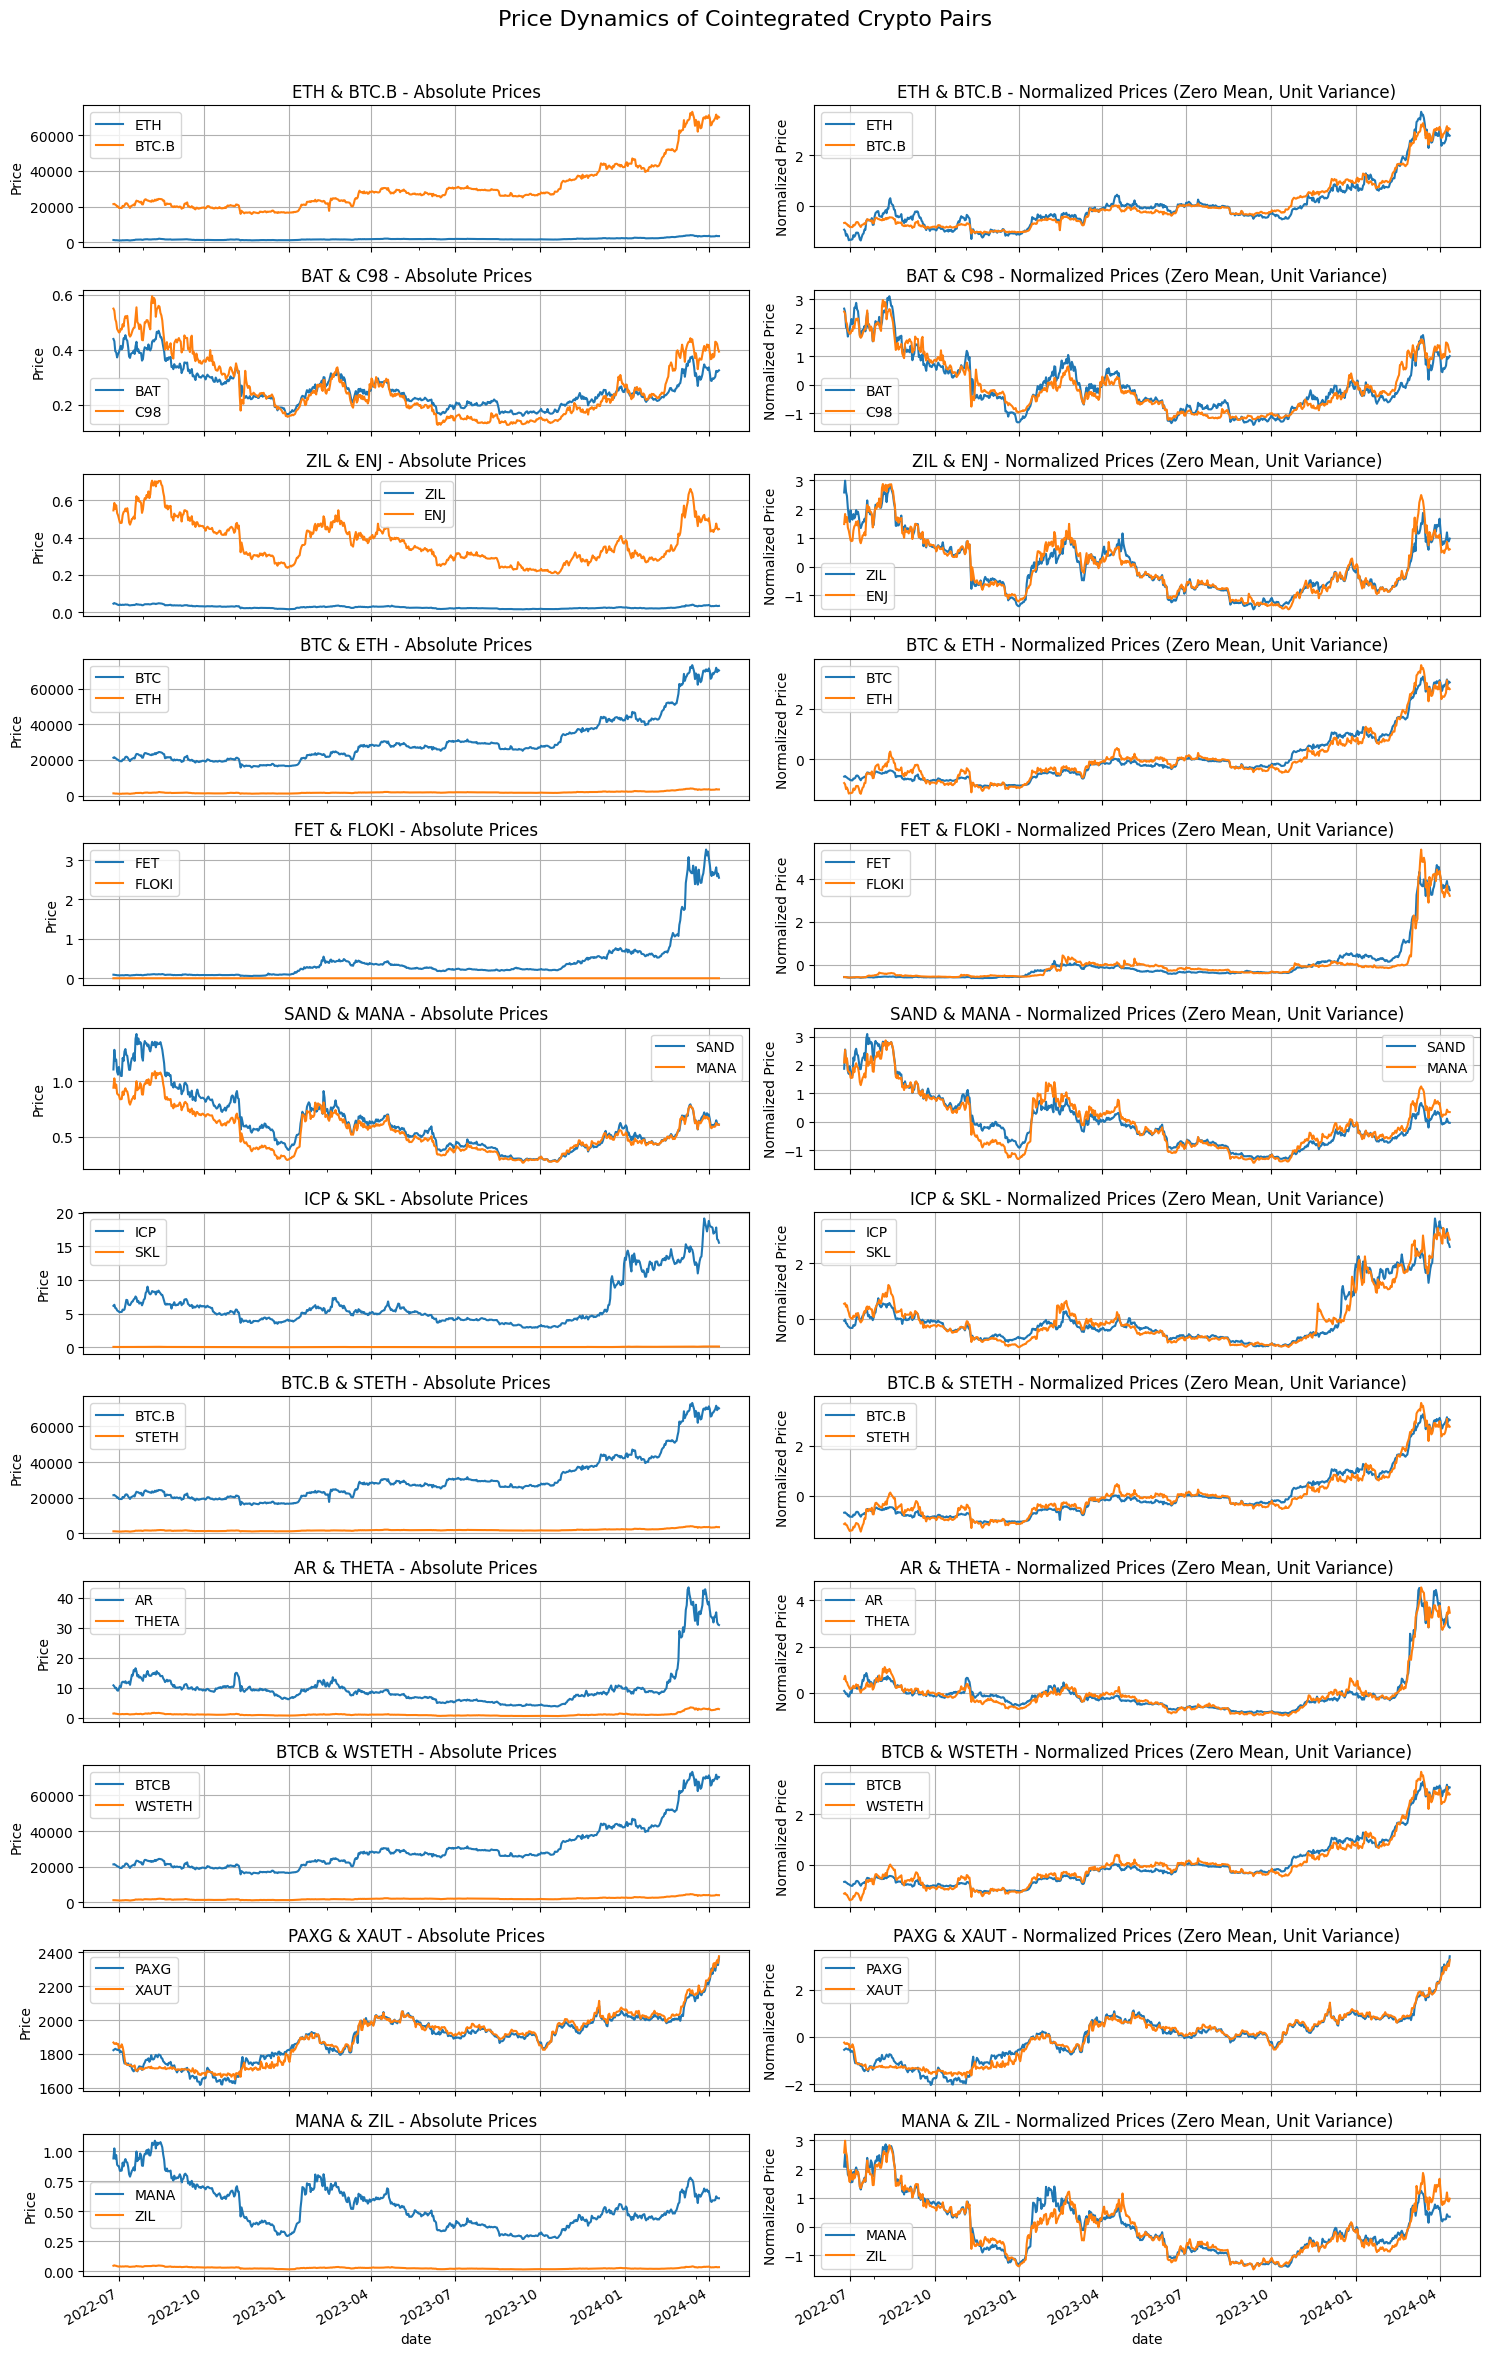

In [5]:
final_pairs = get_cointegrated_pairs(prices=train_df)

def comparison_absolute_vs_norm_prices(pair, train, train_norm, ax1, ax2):
    # Plot raw prices
    train[pair].plot(ax=ax1)
    ax1.set_title(f"{pair[0]} & {pair[1]} - Absolute Prices")
    ax1.set_ylabel("Price")
    ax1.grid(True)

    # Plot normalized prices
    train_norm[pair].plot(ax=ax2)
    ax2.set_title(f"{pair[0]} & {pair[1]} - Normalized Prices (Zero Mean, Unit Variance)")
    ax2.set_ylabel("Normalized Price")
    ax2.grid(True)

# Convert final_pairs to a list of lists (if it's a NumPy array)
final_pairs_list = final_pairs.tolist()

# Normalize prices once
train_norm = pd.DataFrame(
    StandardScaler().fit_transform(train_df),
    index=train_df.index,
    columns=train_df.columns
)

# Create a large figure with subplots
num_pairs = len(final_pairs_list)
fig, axs = plt.subplots(num_pairs, 2, figsize=(15, 2 * num_pairs), sharex=True)

for i, pair in enumerate(final_pairs_list):
    ax1 = axs[i, 0]
    ax2 = axs[i, 1]
    comparison_absolute_vs_norm_prices(pair, train_df, train_norm, ax1, ax2)

plt.suptitle("Price Dynamics of Cointegrated Crypto Pairs", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [6]:
final_pairs

array([['ETH', 'BTC.B'],
       ['BAT', 'C98'],
       ['ZIL', 'ENJ'],
       ['BTC', 'ETH'],
       ['FET', 'FLOKI'],
       ['SAND', 'MANA'],
       ['ICP', 'SKL'],
       ['BTC.B', 'STETH'],
       ['AR', 'THETA'],
       ['BTCB', 'WSTETH'],
       ['PAXG', 'XAUT'],
       ['MANA', 'ZIL']], dtype=object)

### Step 3: Generate Rolling Spreads and Z-Score Signals with Dynamic Alpha and Beta

After identifying cointegrated crypto pairs, the next step is to monitor and trade these relationships over time. However, in real markets — especially in the crypto space — the statistical relationship between two assets (like their hedge ratio) is might not be static. That's why we use a rolling window approach to dynamically estimate the spread and generate trading signals.

In classical pairs trading, alpha (intercept) and beta (hedge ratio) are estimated once over a fixed historical window. This assumes a stable relationship between the two assets. But in crypto, where market conditions change rapidly due to news, liquidity, and structural shifts, that assumption often breaks down.

Instead, we recalculate alpha and beta using a sliding window (e.g., 90 days) across time. This allows the strategy to adapt to new market regimes, making it more robust and responsive.

- **Rolling Beta**:  
  The hedge ratio is estimated from a rolling covariance and variance of the two assets.
  
  $$
  \beta_t = \frac{\text{Cov}(P^A, P^B)}{\text{Var}(P^A)}
 $$

- **Rolling Alpha**:  
  The intercept is dynamically calculated to adjust the spread to recent means:
  
  $$
  \alpha_t = \bar{P}^B - \beta_t \cdot \bar{P}^A
  $$

- **Rolling Spread**:  
  The spread is computed at each time point using the current rolling beta and alpha:
  
  $$
  \text{Spread}_t = P^B_t - (\beta_t \cdot P^A_t + \alpha_t)
  $$

- **Rolling Z-score**:  
  The spread is then standardized over the same window to produce the trading signal:
  
  $$
  Z_t = \frac{\text{Spread}_t - \mu_t}{\sigma_t}
  $$

This Z-score becomes your trading signal where typical entry/exit rules are:

- **Enter trade** when $ |Z_t| > 1 $ (e.g., long the spread if $ Z_t < -1 $, short if $ Z_t > 1 $)
- **Exit trade** when $ Z_t \approx 0 $

The above steps enables us to build a fully dynamic, mean-reverting trading strategy that adapts to evolving relationships in the crypto market.

In [7]:
rolling_params = get_rolling_signals(
    prices=pd.concat([train_df, val_df], axis=0), 
    select_pairs=final_pairs, 
    rolling_window=14
)

print("For pair", final_pairs[0], ":")
pd.concat(rolling_params[tuple(final_pairs[0])], axis=1)

For pair ['ETH' 'BTC.B'] :


,rolling_alpha,rolling_beta,rolling_spread,rolling_z_score
date,,,,
2022-06-25,NaN,NaN,NaN,NaN
2022-06-26,NaN,NaN,NaN,NaN
2022-06-27,NaN,NaN,NaN,NaN
2022-06-28,NaN,NaN,NaN,NaN
2022-06-29,NaN,NaN,NaN,NaN
...,...,...,...,...
2025-01-06,42230.302488,15.584505,-1.571867e+06,0.141087
2025-01-07,34945.811725,17.754804,-1.844626e+06,-0.668759
2025-01-08,38214.494122,16.816772,-1.666289e+06,0.063038


### Step 4: Generate Trading Signals from Rolling Z-Scores

After computing rolling alpha, beta, and Z-score for each cointegrated pair, we now translate those Z-scores into actual trading signals The Z-score reflects how far the current spread is from its rolling average in units of standard deviation — and this deviation becomes the core signal for a mean-reversion strategy.

We have already computed the rolling Z-scores defined as:

$$
Z_t = \frac{\text{Spread}_t - \mu_t}{\sigma_t}
$$

Where:
- $ \text{Spread}_t $: The current value of the spread (e.g., $ P^A_t - \beta_t P^B_t $)
- $ \mu_t $: The mean of the spread over a recent rolling window
- $ \sigma_t $: The standard deviation of the spread over that same window

This standardization allows us to consistently interpret the spread across different asset pairs and time periods.


#### Trading Logic Based on Z-Score Thresholds:

We assume the spread will revert to its mean, so we build a long/short position whenever it deviates "too much" from its recent average.

The typical signal logic is:

- **Go Short the Spread** (Z > +entry threshold):
  - The spread is **too high** compared to its mean.
  - Expect it to come down → short the leading leg, long the lagging leg.
  
- **Go Long the Spread** (Z < –entry threshold):
  - The spread is **too low**.
  - Expect it to rise → long the leading leg, short the lagging leg.

- **Exit Position** (|Z| < exit threshold):
  - The spread has mean-reverted.
  - Close both legs of the trade.


#### Thresholds:

| Threshold         | Typical Value | Meaning                             |
|------------------|----------------|--------------------------------------|
| `entry_threshold`| 1.0 or 1.5     | Signal triggers outside this range   |
| `exit_threshold` | 0.2 or 0.0     | Close the position within this band  |

These thresholds help filter noise and avoid overtrading during low-volatility periods.

### Backtesting
Once long-short signals are generated, the next step is to simulate how the strategy would have performed if we had executed those signals historically. This is done through a vectorized backtest where we apply the trading signals to actual asset price movements and compute portfolio returns. The core logic of the backtest includes:

1. **Compute Daily Returns**  
   - Use percentage changes of prices to represent each asset's daily return.

2. **Simulate Execution**  
   - We assume trades are executed at the **close of day $ t $**, based on signals generated at the same close. The return earned from that trade is realized between **day $ t $ and $ t + 1 $**.
   
3. **Apply Trading Signals to Returns**  
   - Multiply each asset's position (+1 for long, –1 for short) by the next-day return to calculate daily PnL.

4. **Aggregate Across All Positions**  
   - Sum the individual PnLs to get the daily return of the full portfolio. Optionally normalize by gross exposure (total absolute weights).



#### Why Use `.shift(1)` in the Signals?

This is **crucial** to avoid **lookahead bias** and simulate **realistic trading**:

| Without Shift        | With `.shift(1)` |
|----------------------|------------------|
| Signals are applied to the same day's return → unrealistic (requires future info) | Signals are applied to next day's return → realistic (acts on today's signal, gets return tomorrow) |
| Implies you knew how the price would move before it moved | Respects causal timeline: decision made at time \( t \), return observed at \( t+1 \) |

In [8]:
performance_metrics = []
results = []

for ent_thresh in np.arange(0.4, 1.0, 0.01):
    for exit_thresh in np.arange(0.1, 0.5, 0.01):
        all_positions = get_long_short_signals(
            prices=val_df, 
            select_pairs=final_pairs, 
            rolling_params=rolling_params, 
            entry_threshold=round(ent_thresh, 2), 
            exit_threshold=round(exit_thresh, 2)
        )

        all_returns = (all_positions.shift(+1) * val_df[all_positions.columns].pct_change())

        pair_wise_returns = pd.concat([all_returns[p].sum(axis=1).rename("_".join(p)) for p in final_pairs], axis=1)

        res = pair_wise_returns.mean(axis=1).rename(
            f"{round(ent_thresh, 2)} Entry Thresh & {round(exit_thresh, 2)} Exit Thresh"
        )

        results.append(res)

        performance_metrics.append(
            pd.DataFrame(
                compute_performance_metrics(
                    strategy_returns=res, 
                    benchmark_returns=val_df["BTC"]
                )
            ).T.set_index(
                pd.MultiIndex.from_tuples(
                    [(round(ent_thresh, 2), round(exit_thresh, 2))], 
                    names=["Entry Threshold", "Exit Threshold"]
                )
            )
        )

performance_metrics_grid = pd.concat(performance_metrics).reset_index()

### Threshold Surface Analysis: Entry vs Exit Impact on Strategy Performance
Before finalizing the trading rules, it’s essential to understand how the strategy responds to different combinations of entry and exit thresholds. To achieve this, we conducted a grid search over a range of threshold values (computed in previous segment) and visualize their effects using 3D surface plots below.

These plots help uncover the combinations that produce the most robust performance, while avoiding overfitting to one specific configuration. This is a critical step in any quantitative research process, as it aids in:

- Detecting stable performance regions
- Avoiding brittle parameters that work only at isolated values
- Balancing returns with risk metrics like drawdown and volatility
- Ensuring the strategy is not just benchmark-tracking (via low R-squared)

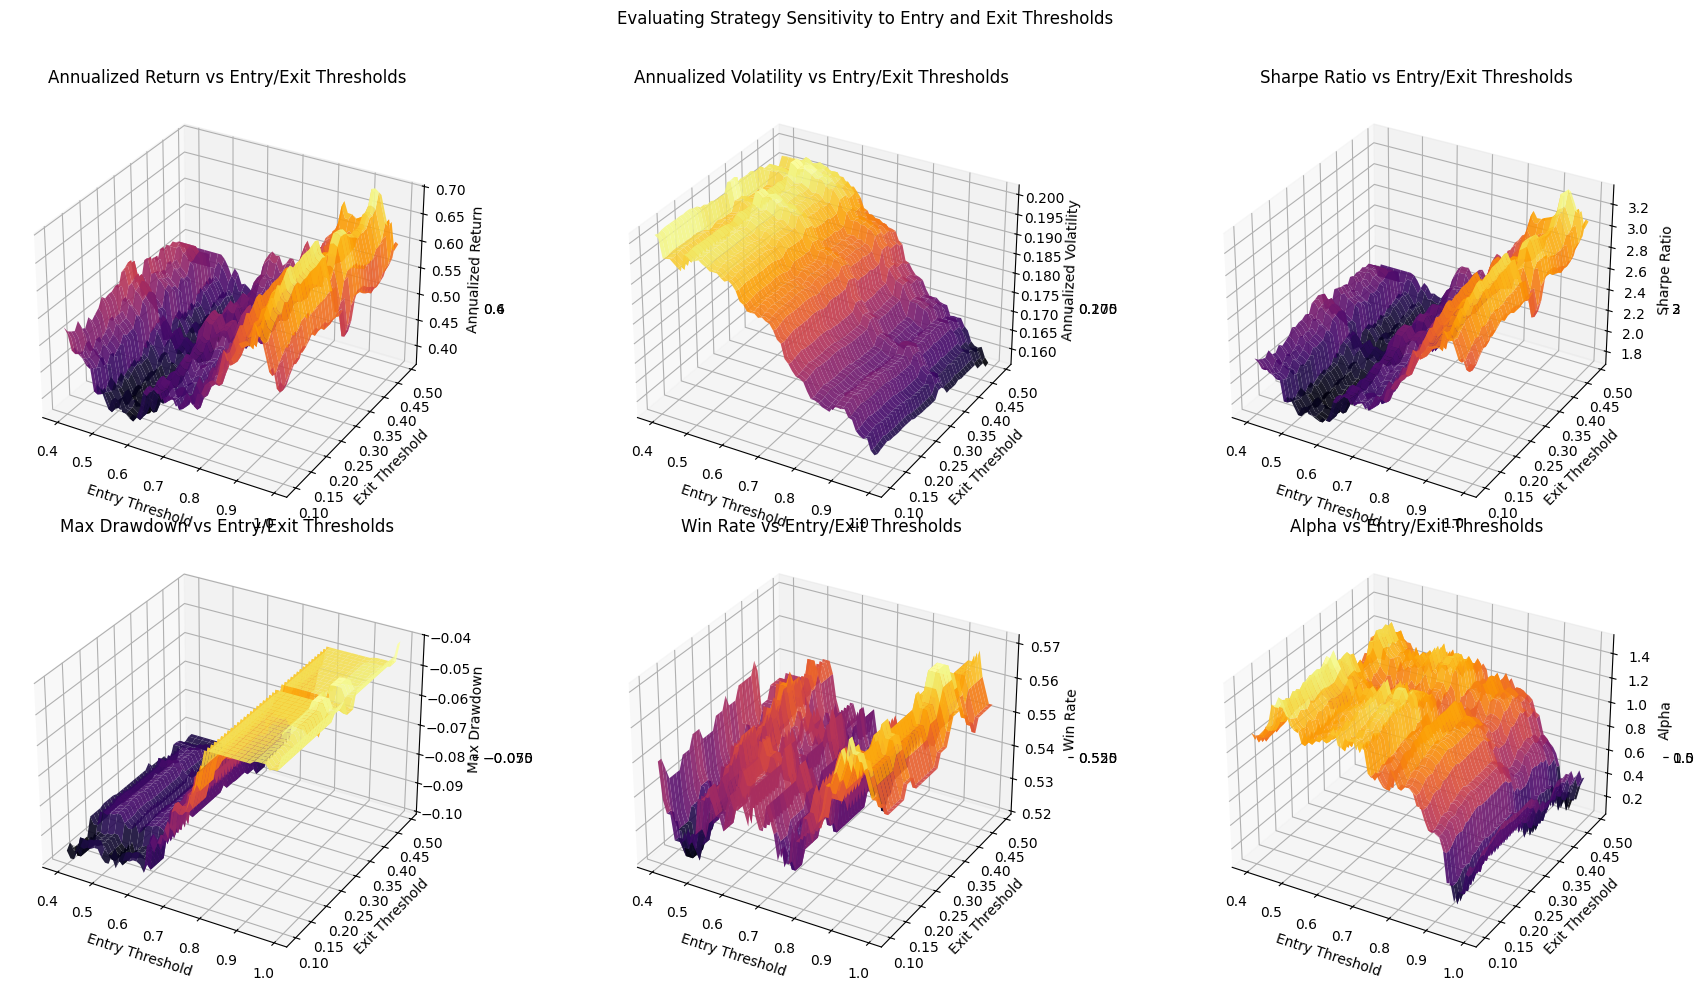

In [10]:
create_surface_plots(
    df=performance_metrics_grid,
    values=["Annualized Return", "Annualized Volatility", "Sharpe Ratio", "Max Drawdown", "Win Rate", "Alpha"],
    cmap="inferno"
)

plt.show()

### Composite Score: Multi-Metric Strategy Selection

To select the most robust parameter combination, we construct a composite score that blends multiple performance metrics into a single ranking value. This score allows us to balance return potential with risk control and independence from the market benchmark.

Metrics Breakdown:
- **Sharpe Ratio (25%)**: Measures risk-adjusted returns. A high Sharpe indicates consistency and statistical robustness. It’s given the highest weight as it's a core indicator of performance quality.
- **Alpha (70%)**: Captures excess return over the benchmark (e.g., BTC). This represents true skill rather than just market exposure. Equal in importance to Sharpe in identifying strategies that generate independent value.
- **Max Drawdown (9%)**: Reflects the worst-case loss over the period. Lower drawdowns imply better capital preservation — especially important in volatile crypto environments.
- **R-squared (1%)**: Indicates how much of the strategy’s behavior is explained by the benchmark. Lower R² values mean the strategy is more market-neutral and potentially diversifying. This is lightly penalized to avoid benchmark hugging.


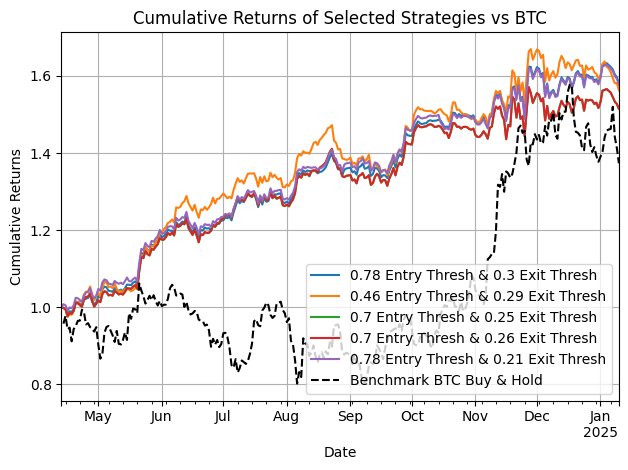

In [11]:
performance_metrics_grid["Composite Score"] = (
    performance_metrics_grid["Sharpe Ratio"].rank(pct=True) * 0.25 +     # Risk-adjusted return
    performance_metrics_grid["Alpha"].rank(pct=True) * 0.7 +           # Benchmark outperformance
    performance_metrics_grid["Max Drawdown"].rank(pct=True, ascending=True) * 0.09 +  # Low drawdowns
    performance_metrics_grid["R-squared"].rank(pct=True, ascending=True) * 0.01        # Lower tracking
)

for i in performance_metrics_grid.sort_values(by=["Composite Score"], ascending=False).index[:5]:
    (1 + results[i]).cumprod().plot()

# Add BTC benchmark
(1 + val_df["BTC"].pct_change()).cumprod().plot(label="Benchmark BTC Buy & Hold", linestyle="--", color="black")

plt.legend(loc="lower right")
plt.title("Cumulative Returns of Selected Strategies vs BTC")
plt.ylabel("Cumulative Returns")
plt.xlabel("Date")
plt.tight_layout()
plt.grid(True)
plt.show()

### Step 5: Out-of-Sample (Test Set) Performance Evaluation

After selecting the optimal entry and exit thresholds, we evaluate the strategy on the test set to simulate real-world performance. This final assessment ensures that the strategy generalizes well beyond the data it was tuned on.

The table below summarizes key performance metrics such as:

- **Cumulative and Annualized Return**
- **Risk-adjusted Metrics** (Sharpe Ratio, Sortino Ratio)
- **Max Drawdown**
- **Benchmark-relative Stats** (Alpha, Beta, R-squared)
- **Trade Quality** (Win Rate, Profit Factor)

These metrics offer a comprehensive view of how the strategy performs in a truly unseen environment, helping validate its robustness and deployment readiness.


In [12]:
test_positions = get_long_short_signals(
    prices=test_df,
    select_pairs=final_pairs,
    rolling_params=get_rolling_signals(
        prices=pd.concat([train_df, val_df, test_df], axis=0),
        select_pairs=final_pairs, 
        rolling_window=14
    ),
    entry_threshold=0.46,
    exit_threshold=0.29
)

test_returns = test_positions.shift(+1) * test_df[test_positions.columns].pct_change()

test_pair_wise_returns = pd.concat(
    [test_returns[pair].sum(axis=1).rename("_".join(pair)) for pair in final_pairs], 
    axis=1
)

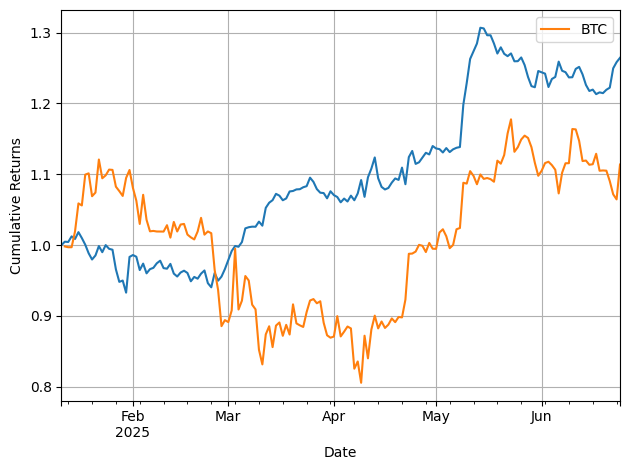

In [13]:
(1 + test_pair_wise_returns.mean(axis=1)).cumprod().plot()
(1 + test_df["BTC"].pct_change()).cumprod().plot()
plt.ylabel("Cumulative Returns")
plt.xlabel("Date")
plt.tight_layout()
plt.grid(True)
plt.legend()

In [14]:
from IPython.display import display, Markdown

display(Markdown("### Out-of-Sample (Test Set) Performance Metrics:"))

display(pd.DataFrame(
    compute_performance_metrics(
        strategy_returns=test_pair_wise_returns.mean(axis=1),
        benchmark_returns=test_df["BTC"]
    )
).T)


### Out-of-Sample (Test Set) Performance Metrics:

,Holding Period (Days),Holding Period (Months),Holding Period (Years),Cumulative Return,Annualized Return,Annualized Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown,Win Rate,Avg Win,Avg Loss,Profit Factor,Alpha,Beta,R-squared
0,165.0,7.86,0.65,0.264369,0.430833,0.187379,2.005568,3.72624,-0.083889,0.539394,0.009222,-0.007662,1.428189,2.602928,-9.251248e-08,0.005122
